**mlops zoomcamp 2023 by DataTalksClub**

**homework 1**

This notebook is for the first homework of the mlops course. The goals are to explore the data and to train a model to predict the duration of a ride.

Data is from [NYC taxi dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page), specifically the "Yellow Taxi Trip Records" from january, february 2022.

**Author**: Hugo Valenzuela

# Building a simple linear regression model to predict taxi rides duration

## Libraries

In [43]:
# the basics
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
# sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

## Importing data

In this case data is in parquet format, so we use pandas to read it.

We read the data that will be use for training and testing as well.

*Train data*: data from january 2022

*Test data*: data from february 2022

In [3]:
df_train = pd.read_parquet('./data/yellow_tripdata_2022-01.parquet') #may require pyarrow installed
df_test = pd.read_parquet('./data/yellow_tripdata_2022-02.parquet')

## Exploring the data

In [4]:
df_train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [5]:
df_test.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-02-01 00:06:58,2022-02-01 00:19:24,1.0,5.40,1.0,N,138,252,1,17.0,1.75,0.5,3.90,0.00,0.3,23.45,0.0,1.25
1,1,2022-02-01 00:38:22,2022-02-01 00:55:55,1.0,6.40,1.0,N,138,41,2,21.0,1.75,0.5,0.00,6.55,0.3,30.10,0.0,1.25
2,1,2022-02-01 00:03:20,2022-02-01 00:26:59,1.0,12.50,1.0,N,138,200,2,35.5,1.75,0.5,0.00,6.55,0.3,44.60,0.0,1.25
3,2,2022-02-01 00:08:00,2022-02-01 00:28:05,1.0,9.88,1.0,N,239,200,2,28.0,0.50,0.5,0.00,3.00,0.3,34.80,2.5,0.00
4,2,2022-02-01 00:06:48,2022-02-01 00:33:07,1.0,12.16,1.0,N,138,125,1,35.5,0.50,0.5,8.11,0.00,0.3,48.66,2.5,1.25


In [6]:
## some info about the dataframe

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2979431 entries, 0 to 2979430
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [7]:
# shape of the dataframes (rows, columns)
print('train df shape:', df_train.shape)
print('test df shape:', df_test.shape)

train df shape: (2463931, 19)
test df shape: (2979431, 19)


## Selecting the variables

In this particular project, we'll only use the IDs and times for pickup and drop off, so we can delete the other columns.

Also we convert the IDs variables to "object" as they are read initially as integers.

In [14]:
def select_columns(df):
    # select columns and convert ids to strings (object type)
    columnas = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 
                  'PULocationID', 'DOLocationID']
    categorical = ['PULocationID', 'DOLocationID']
    df = df.loc[:, tuple(columnas)]
    df[categorical] = df[categorical].astype(str)
    return df

In [15]:
df_train = select_columns(df_train)

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 4 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   PULocationID           object        
 3   DOLocationID           object        
dtypes: datetime64[ns](2), object(2)
memory usage: 75.2+ MB


In [17]:
df_test = select_columns(df_test)

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2979431 entries, 0 to 2979430
Data columns (total 4 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   PULocationID           object        
 3   DOLocationID           object        
dtypes: datetime64[ns](2), object(2)
memory usage: 90.9+ MB


## Computing duration of the rides

We need to create a new column that will be our targer variable. That is "duration" and will be computed as the diference between the *dropoff dateime* and the *pickup datetime*:

```tpep_dropoff_datetime``` -  ```tpep_pickup_datetime```

Let's define a function that computes and creates this column, giving the results in minutes

In [19]:
(df_train['tpep_dropoff_datetime'] - df_train['tpep_pickup_datetime']).iloc[3].total_seconds()
# the resulting object type of the timing difference is timedelta

602.0

In [20]:
def compute_duration(df):
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60) #divide to obtain minutes
    return df

### train data

In [21]:
df_train = compute_duration(df_train)

In [22]:
compute_duration(df_train).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,duration
0,2022-01-01 00:35:40,2022-01-01 00:53:29,142,236,17.816667
1,2022-01-01 00:33:43,2022-01-01 00:42:07,236,42,8.400000
2,2022-01-01 00:53:21,2022-01-01 01:02:19,166,166,8.966667
3,2022-01-01 00:25:21,2022-01-01 00:35:23,114,68,10.033333
4,2022-01-01 00:36:48,2022-01-01 01:14:20,68,163,37.533333


### test data

In [23]:
df_test = compute_duration(df_test)

In [24]:
compute_duration(df_test).head()

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,duration
0,2022-02-01 00:06:58,2022-02-01 00:19:24,138,252,12.433333
1,2022-02-01 00:38:22,2022-02-01 00:55:55,138,41,17.550000
2,2022-02-01 00:03:20,2022-02-01 00:26:59,138,200,23.650000
3,2022-02-01 00:08:00,2022-02-01 00:28:05,239,200,20.083333
4,2022-02-01 00:06:48,2022-02-01 00:33:07,138,125,26.316667


## Filtering outliers

We can plot the boxplot of the duration variable, and we can filter the outliers.
In particular, in this project we are asked to filter and keep the records between 1 and 60 minutes of ride duration.

<Axes: xlabel='duration'>

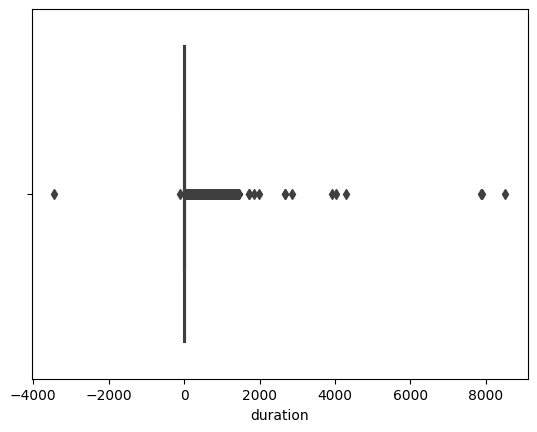

In [25]:
sns.boxplot(data=df_train, x="duration")

**standard deviation of the duration variable**

In [26]:
print('standard deviation of duration variable', df_train.duration.describe()['std'])

standard deviation of duration variable 46.44530513776802


### Keeping records between 1 and 60 minutes

#### Train data

In [27]:
df_train_filtered = df_train[(df_train.duration >= 1) & (df_train.duration <= 60)]

<Axes: xlabel='duration', ylabel='Density'>

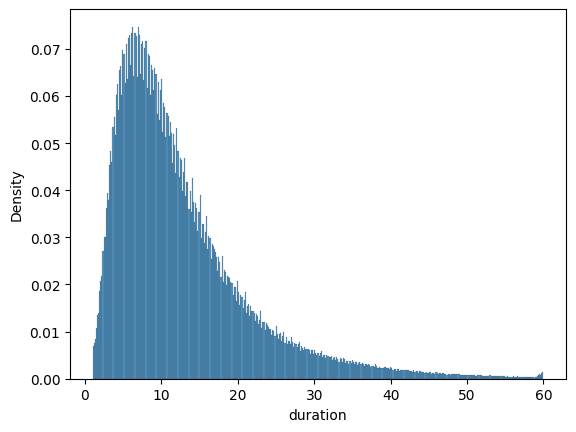

In [28]:
sns.histplot(data=df_train_filtered, x='duration', stat='density')

**fractions of records in train data left after removing outliers**

In [29]:
print('fraction of records left', df_train_filtered.shape[0] / df_train.shape[0])

fraction of records left 0.9827547930522406


#### Test data

In [30]:
df_test_filtered = df_test[(df_test.duration >= 1) & (df_test.duration <= 60)]

## One-hot encoding

We can drop now the columns of pick-up and drop-off time as we already have the duration computed

In [34]:
df_train_filtered.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

,PULocationID,DOLocationID,duration
0,142,236,17.816667
1,236,42,8.400000
2,166,166,8.966667
3,114,68,10.033333
4,68,163,37.533333
...,...,...,...
2463926,90,170,5.966667
2463927,107,75,10.650000
2463928,113,246,11.000000
2463929,148,164,12.050000


In [35]:
df_test_filtered.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

,PULocationID,DOLocationID,duration
0,138,252,12.433333
1,138,41,17.550000
2,138,200,23.650000
3,239,200,20.083333
4,138,125,26.316667
...,...,...,...
2979426,163,193,16.000000
2979427,141,4,12.250000
2979428,161,151,15.333333
2979429,141,226,8.266667


### using dicvectorizer to do one-hot encoding

In [36]:
features = ['PULocationID', 'DOLocationID']
label = ['duration']

dv = DictVectorizer()

#### features

In [38]:
train_dicts = df_train_filtered[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

test_dicts = df_test_filtered[features].to_dict(orient='records')
X_test = dv.transform(test_dicts)

let's see the dimensionality of the training data with one-hot encoding

In [46]:
X_train.shape

(2421440, 515)

#### labels

In [41]:
y_train = df_train_filtered[label].values
y_test = df_test_filtered[label].values

## Training a linear regression